# 数据加载

In [4]:
import torchvision
import torch
from torch.utils import data
from torchvision import transforms

通过框架的内置函数将Fashion-MNIST数据集下载并读入到内存中

In [5]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root='./data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root='./data', train=False, transform=trans, download=True)

100%|████████████████████████████████████████████████████████████| 26.4M/26.4M [05:12<00:00, 84.5kB/s]
100%|█████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 150kB/s]
100%|█████████████████████████████████████████████████████████████| 4.42M/4.42M [00:07<00:00, 579kB/s]
100%|████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 40.1MB/s]


In [6]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [9]:
mnist_train[0][0].shape
# 第一个 0 -> 样本索引
# 第二个 0 -> 图像数据，第二个 0 的位置变为 1 则是 label

torch.Size([1, 28, 28])

In [10]:
mnist_train[0][1]

9

In [12]:
def get_fashion_mnist_labels(labels):
    """ 返回fashion-MNIST图像的文本标签 """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

import matplotlib.pyplot as plt
import torch

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    # 创建子图
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # 将axes数组展平，便于迭代
    axes = axes.flatten()
    
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量，转换为numpy数组
            ax.imshow(img.numpy())
        else:
            # PIL图片或其他数组格式
            ax.imshow(img)
        
        # 隐藏坐标轴
        ax.set_xticks([])
        ax.set_yticks([])
        
        # 设置标题（如果提供）
        if titles is not None:
            ax.set_title(titles[i])
    
    # 调整子图间距
    plt.tight_layout()
    return axes

几个样本的图像以及对应的标签

array([<Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'dress'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'pullover'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 't-shirt'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sandal'}>,
       <Axes: title={'center': 'sneaker'}>,
       <Axes: title={'center': 'ankle boot'}>,
       <Axes: title={'center': 'trouser'}>,
       <Axes: title={'center': 't-shirt'}>], dtype=object)

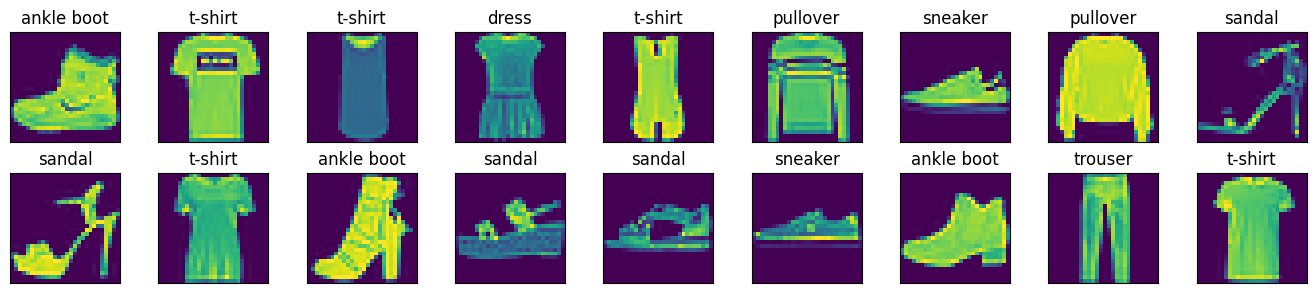

In [13]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [16]:
batch_size = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size=batch_size, 
                             shuffle=True, num_workers=get_dataloader_workers())

import time

start_time = time.time()

for X, y in train_iter:
    continue

end_time = time.time()
delta = end_time - start_time
print(f'用时{delta : .2f} sec')

用时 0.47 sec


整合所有组件，用于获取和读取Fashion-MNIST数据集。
这个函数返回训练集和验证集的数据迭代器。
此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

In [19]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, 
                                                   transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, 
                                                   transform=trans, download=True)

    return (data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, 
                          num_workers=get_dataloader_workers()), 
            data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, 
                          num_workers=get_dataloader_workers()))

指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能

In [21]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64
